# Animations GW

# Loading relevant libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import UsefulFunctions as uf
import os
import netCDF4 as nc
from collections import OrderedDict
from glob import glob
%matplotlib inline

# Setting up paralellisation prior to analysis

In [2]:
client = Client(n_workers = 12)

In [2]:
varDict = OrderedDict([
    ('temp', {'model': 'ACCESS-ESM1-5',
              'var_id': 'bigthetao',
              'exp': 'esm-ssp585', 
              'variant': 'r1i1p1f1',
              'freq': 'mon',
              'long_name': 'water temperature', #Used mainly to label graphs
              'short_name': 'temp', #Used mainly to label graphs
              'means': r'/g/data/v45/la6889/MEASO/Summaries/SO_1900-2100/Temperature/Means'}),
    ('SIC', {'model': 'ACCESS-ESM1-5',
              'var_id': 'siconc',
              'exp': 'historical', 
              'variant': 'r1i1p1f1',
              'freq': 'mon',
              'long_name': 'sea ice concentration', #Used mainly to label graphs
              'short_name': 'sic', #Used mainly to label graphs
              'means': r'/g/data/v45/la6889/MEASO/Summaries/SO_1900-2100/SIC/Means'})])

In [3]:
var = 'SIC'
time = np.arange(1900, 2014, 10)
depths = [0, 10]

In [4]:
from clef.code import *
db = connect()
s = Session()
search_dict = {'variable_id': varDict[var]['var_id'], 
               'model': varDict[var]['model'], 
               'frequency': varDict[var]['freq'], 
              'experiment_id': varDict[var]['exp'], 
               'variant_label': varDict[var]['variant']}
df = search(s, project = 'CMIP6', latest = True, **search_dict)

In [5]:
# set(df.experiment_id)
folder_path = [f for f in df['path'] if varDict[var]['variant'] in f]
# len(folder_path)
filenames = sorted(glob(os.path.join(folder_path[0], '*.nc')))
filenames

['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/SImon/siconc/gn/v20200817/siconc_SImon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc']

In [6]:
#Searching variable of interest in database
var_int = uf.searchACCESS(var = varDict[var]['var_id'], 
                       model = varDict[var]['model'], 
                       freq = varDict[var]['freq'], 
                       exp = varDict[var]['exp'], 
                       # time_frame = time, 
                       variant = varDict[var]['variant'])

In [7]:
os.makedirs(varDict[var]['means'], exist_ok = True)

In [8]:
for file in var_int:
    var_df = uf.loadData([file], 
                var_name = varDict[var]['var_id'])#,
                # depth_range = depths)
    #Turn dataset to data array
    if type(var_df) == xr.core.dataset.Dataset:
        var_df = var_df[varDict[var]['var_id']]
        
    #Get max and min year values to save file
    minY = var_df.time.dt.year.values.min()
    maxY = var_df.time.dt.year.values.max()
    
    path_out = os.path.join(varDict[var]['means'], f'MonthlyMeans_{minY}-{maxY}.nc')
    var_df.to_netcdf(path_out)

In [9]:
var_df

<xarray.DataArray 'siconc' (time: 1980, latitude: 77, longitude: 360)>
[54885600 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    type       |S7 ...
Attributes:
    standard_name:   sea_ice_area_fraction
    long_name:       Sea-Ice Area Percentage (Ocean Grid)
    comment:         Percentage of grid cell covered by sea ice
    units:           %
    original_units:  1
    history:         2020-08-17T00:32:02Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where sea time: mean
    cell_measures:   area: areacello

In [45]:
var_df = xr.open_dataset(filenames[0]) 

#Turn dataset to data array
if type(var_df) == xr.core.dataset.Dataset:
    var_df = var_df[varDict[var]['var_id']]
    
var_df = uf.corrlong(var_df).sel(latitude = slice(-90, -30))

#Get max and min year values to save file
minY = var_df.time.dt.year.values.min()
maxY = var_df.time.dt.year.values.max()

path_out = os.path.join(varDict[var]['means'], f'MonthlyMeans_SIC_{minY}-{maxY}.nc')
var_df.to_netcdf(path_out)

In [21]:
 #Get max and min year values to save file
    minY = var_df.time.dt.year.values.min()
    maxY = var_df.time.dt.year.values.max()
    
    path_out = os.path.join(varDict[var]['means'], f'MonthlyMeans_{minY}-{maxY}.nc')
    var_df.to_netcdf(path_out)

1909

In [ ]:
for i, file in enumerate(var_int):
    # Loading variable of interest for each time period and depth of interest
    var_df = uf.loadData(filelist = file, 
                      var_name = varDict[var]['var_id'],
                      SO = True, depth_range = depths_interest['surface'])
    
    #Calculate weighted means
    weightedvarMeans = weightedMeans(var_df = var_df, 
                                     weights = vol_df)
    #Create filename
    file_out_m = os.path.join(mean_path_out, 
                            f'WeightedMonthlyMeans_{var}_{depth}_{years[i]}-{years[i+1]}.nc')
    #Save file
    weightedvarMeans.to_netcdf(file_out_m)

# Plotting SST for 2100

In [26]:
sst = xr.open_dataarray('/g/data/v45/la6889/MEASO/Summaries/SO_1900-2100/Temperature/Means/MonthlyMeans_2095-2100.nc')

In [27]:
folder_out = '/g/data/v45/la6889/MEASO/Summaries/SO_1900-2100/Temperature/Means/Figures'
os.makedirs(folder_out, exist_ok = True)

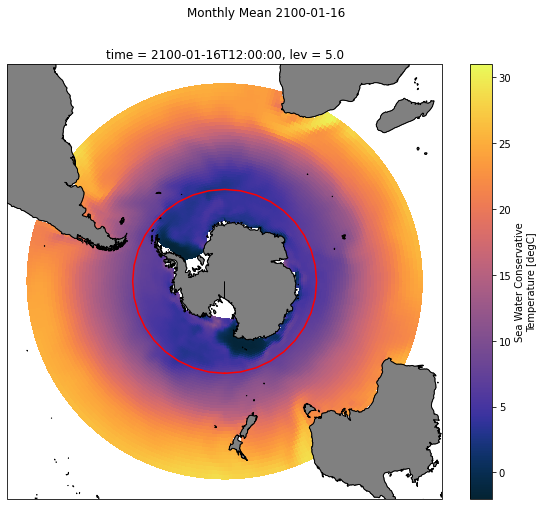

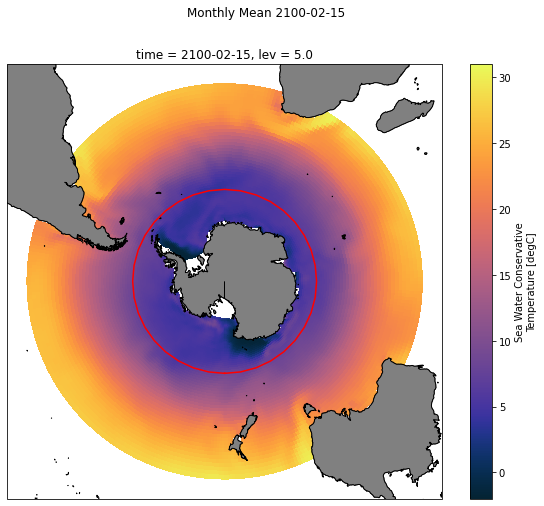

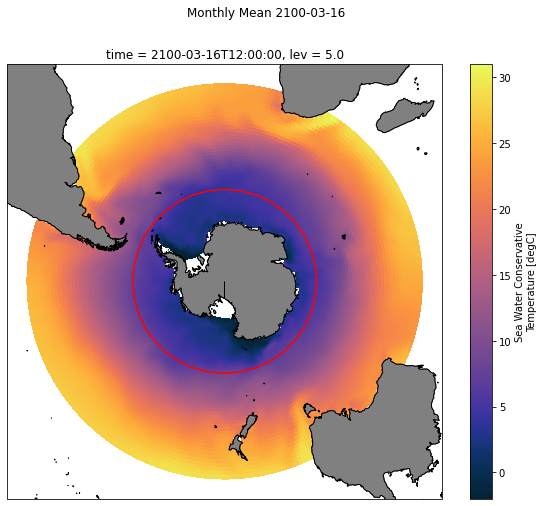

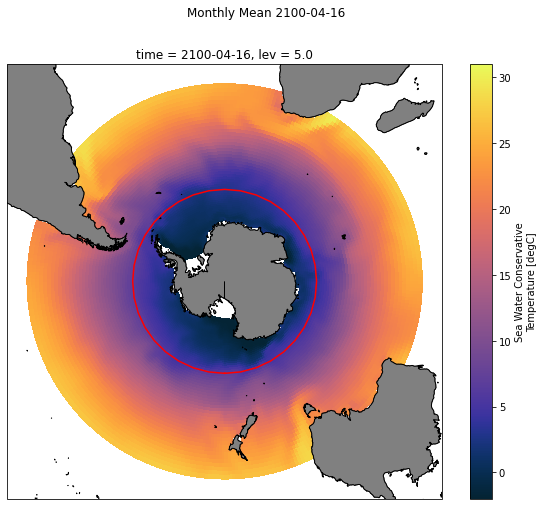

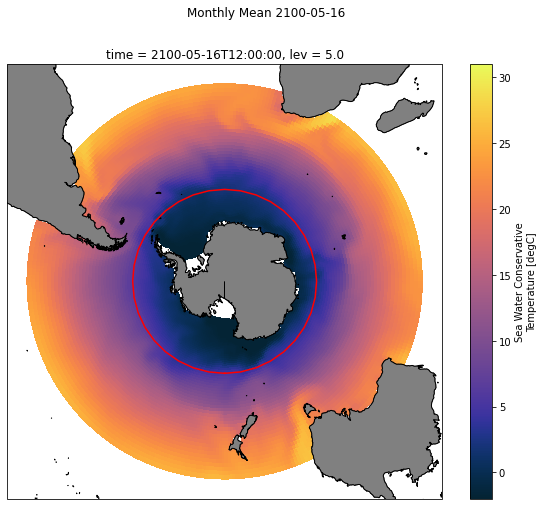

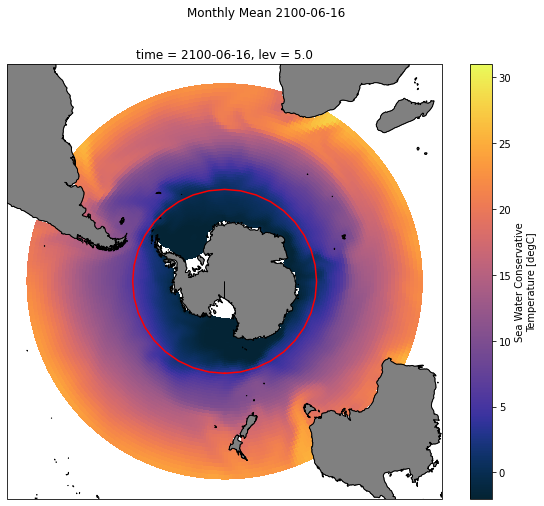

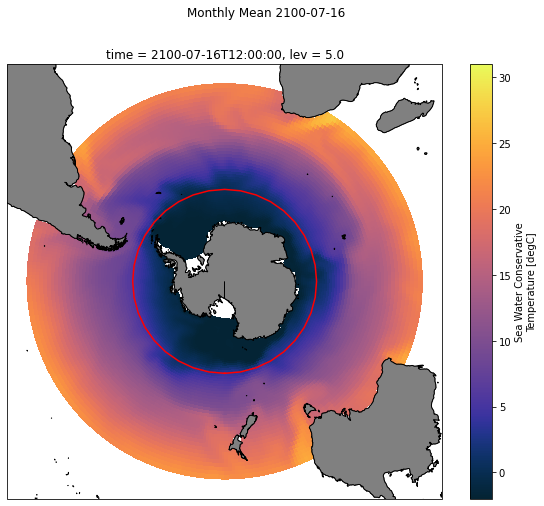

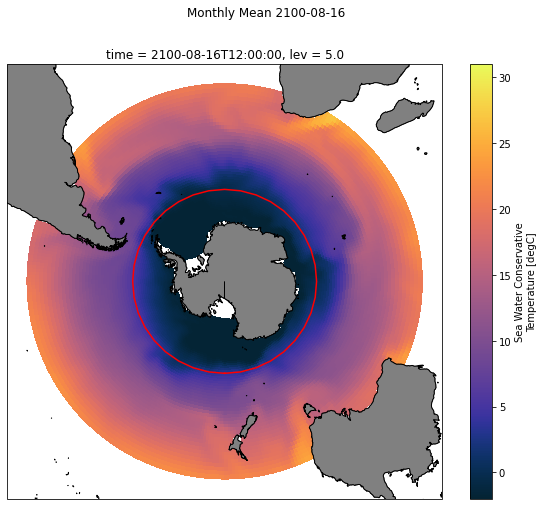

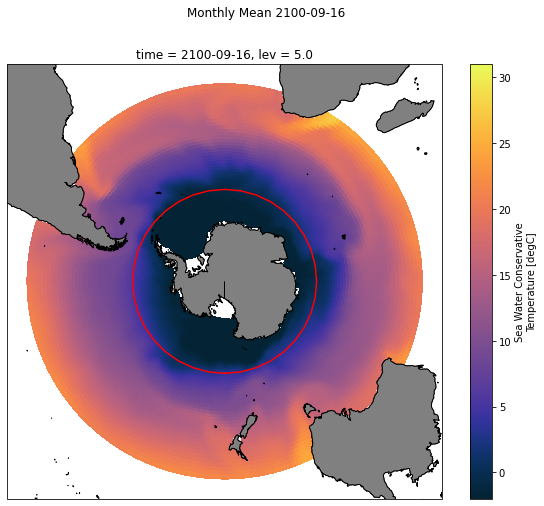

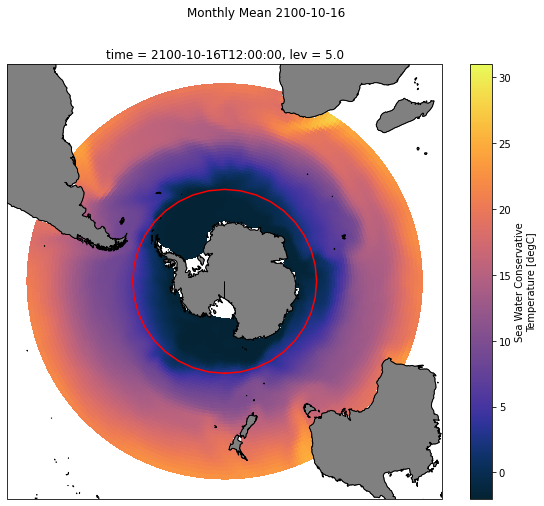

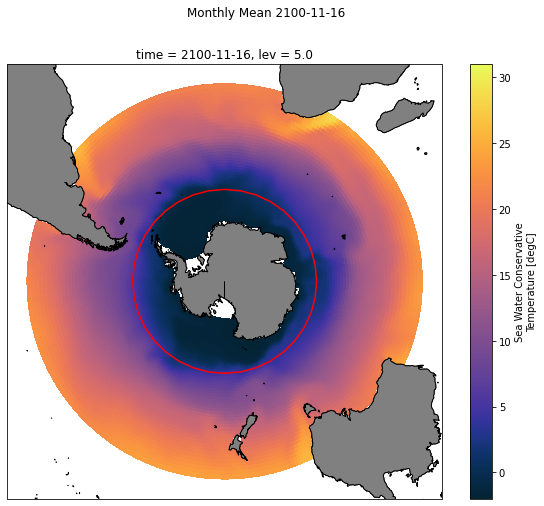

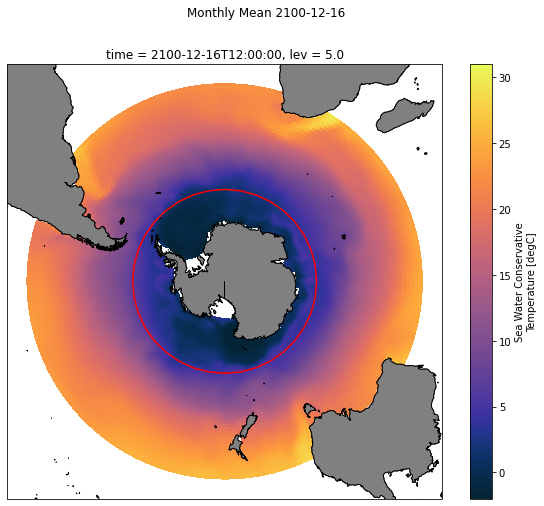

In [36]:
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

sst_2100 = sst.sel(time = '2100')

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

projection = ccrs.SouthPolarStereo()

lon = np.arange(-180, 190, 10)
lat = np.repeat(-60, len(lon))

for j in sst_2100.time.values:
    date = str(j)[0:10]
    fig = plt.figure(figsize = (10, 8))
    ax = fig.add_subplot(111, projection = projection)
    sst_2100.sel(time = j)[0].plot.pcolormesh(x = 'longitude', y = 'latitude', ax = ax,
                                              #Setting colorbar limits to cover range of 
                                              #values in 2100.
                                              cmap = cm.cm.thermal, vmin = -2, vmax = 31,
                                          transform = ccrs.PlateCarree())
    plt.plot(lon, lat, 'red', transform = ccrs.PlateCarree())
    plt.suptitle(f'Monthly Mean {date}')
    
    #Add land and coastlines
    ax.add_feature(land_50m)
    ax.coastlines(resolution = '50m')
    
    file_out = os.path.join(folder_out, f'MonthlyMeansMapSO_{date}.png')
    fig.savefig(file_out, dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)